# <font color='red'>2.1 Importing libraries</font>

In [1]:
# Math, image processing and other useful libraries
from __future__ import print_function, unicode_literals, absolute_import, division
import os

import pandas as pd
import numpy as np
import cv2
from collections import OrderedDict
import copy
import math
import pickle
from matplotlib.ticker import MaxNLocator
from itertools import combinations

# Image processing
from skimage.measure import regionprops
from skimage.filters import meijering, sato, frangi, hessian, threshold_otsu
from skimage.morphology import extrema, skeletonize
from skimage.transform import probabilistic_hough_line
from skimage.draw import disk, circle_perimeter
from scipy.ndimage import gaussian_filter, grey_closing
from scipy.spatial import distance_matrix
from skimage import data, restoration, util
from roipoly import RoiPoly
from matplotlib_scalebar.scalebar import ScaleBar
from biosppy.signals import tools
from biosppy.stats import pearson_correlation
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Plotting
import matplotlib.pyplot as plt
import matplotlib.cm as pltc
import matplotlib.colors as colors
import seaborn as sns

# Widgets
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
from IPython.display import display

# Feature Extraction (.py files by Teresa Parreira)
# from CytoSkeletonPropsMorph import CytoSkeletonPropsMorph
# from CytoSkeletonRegionPropsInt import RegionPropsInt
# from FreqAnalysis import FreqAnalysis
# from GLCM import GLCM

# Graph
import sknw
import networkx as nx
from scipy.signal import argrelextrema

# 
from skan import Skeleton, summarize,draw
from skan.csr import skeleton_to_csgraph, sholl_analysis,make_degree_image
import scipy as sp
import scipy.sparse
from matplotlib.patches import Circle
from ImageFeatures import ImageFeatures
from Functions import label_image, FeaturesFromCentroid, cv2toski,pylsdtoski,init_import,polar_to_cartesian, truncate_colormap, plot_hist, plot_pie, remove_not1D, quantitative_analysis,hist_bin,hist_lim,create_separate_DFs,branch,graphAnalysis,segment_patches,tif_import_10Z
#from fractal_dimension import fractal_dimension
#from fractal_analysis_fxns import boxcount,boxcount_grayscale,fractal_dimension,fractal_dimension_grayscale,fractal_dimension_grayscale_DBC

print('📚')

utils.py (10): Please use `distance_transform_edt` from the `scipy.ndimage` namespace, the `scipy.ndimage.morphology` namespace is deprecated.
utils.py (10): Please use `binary_fill_holes` from the `scipy.ndimage` namespace, the `scipy.ndimage.morphology` namespace is deprecated.
utils.py (11): Please use `find_objects` from the `scipy.ndimage` namespace, the `scipy.ndimage.measurements` namespace is deprecated.


📚


model2d.py (237): distutils Version classes are deprecated. Use packaging.version instead.
model2d.py (237): distutils Version classes are deprecated. Use packaging.version instead.
model3d.py (275): distutils Version classes are deprecated. Use packaging.version instead.
model3d.py (275): distutils Version classes are deprecated. Use packaging.version instead.


# <font color='red'>2.2 Import and Create DataFrame with available images</font>

In [2]:
global OriginalDF,DeconvDF,NucleiDeconvDF
res = init_import(folder=os.getcwd() + "\\Datasets\\Set 1-a-tubulin_Sofia",
                  options=["original","deconvoluted","nuclei deconvoluted"])
OriginalDF,DeconvDF,NucleiDeconvDF = res[0],res[1],res[2]
#Centroids = pickle.load(open('Centroids_Original.p', 'rb'))
dir_masks = os.getcwd() + '\\Datasets\\10Znuc'
TenDF     = tif_import_10Z(os.getcwd() + "\\Datasets\\10Z")
print('🌠')

🌠


In [3]:
from tifffile import imread, imwrite
from stardist.models import StarDist3D
from csbdeep.utils import Path, normalize
from stardist.geometry import dist_to_coord3D
import napari
#import imea

# def excludeborder(nuc):
#     pxs = list(zip(np.where(nuc > 0)[1],np.where(nuc > 0)[2]))
#     for x in pxs:
#         if 0 in x or 1 in x or 2 in x or 1040 in x or 1039 in x or 1038 in x or 1388 in x or 1387 in x or 1386 in x:
#             return True
#     return False

def process3Dnuclei(dir_masks):

    for img in os.listdir(dir_masks):
        # Get image
        path     = dir_masks + '/' + img
        nuc_mask = imread(path)
        idx = path.split('/')[1].split('_')[0]
        print(idx)
        df = TenDF[TenDF['Channel'] == 0]
        # Initialize DataFrame to put the Centroids in:
        #isolated_nucleus = pd.DataFrame(columns=['ID','Mask With ID','Centroid','Contour'])
        
        # Obtain isolated nucleus
        for nucleus in np.unique(nuc_mask):
            if nucleus != 0: #Not background
#                 try:
                # Obtain isolated nucleus
                aux  = nuc_mask == nucleus
                mask_w_id = aux*nuc_mask
                bin_nuclei = np.where(mask_w_id>0.5, 1, 0)

                global imgg
                imgg = bin_nuclei * (df['Image'][int(idx)] / np.max(df['Image'][int(idx)]))
                imgg = imgg / np.max(imgg)
                global bin_nuclei_
                bin_nuclei_ = np.where(imgg>0, 1, 0)
                xp,yp,zp = np.where(bin_nuclei_>0)
                imgg = imgg[min(xp):max(xp),min(yp):max(yp),min(zp):max(zp)]
                #print(bin_nuclei.shape,np.unique(bin_nuclei))

                feats_all_n                      = ImageFeatures((imgg *255).astype(np.uint8))
                feats_labels_n_, feats_values_n_ = feats_all_n.print_features(print_values = False)
                feats_labels_n_, feats_values_n_ = remove_not1D(feats_labels_n_,feats_values_n_)
                feats_labels_n_                  = ['DNF:' + ftn for ftn in feats_labels_n_]

                return imgg
#                 df_2d, df_3d = imea.shape_measurements_3d(imgg, threshold_mm=0.1, spatial_resolution_xy=0.1612500, spatial_resolution_z=8.7466670)
                
                
                if 'nucDF' not in globals():
                    global nucDF
                    nucDF = pd.DataFrame(columns = ['Img Index'] + ['ID'] + ['Image'] + ['Label'] + list(feats_labels_n_) )
                new   = pd.Series([idx] + [nucleus] + [imgg] + [df['Label'][int(idx)]] + feats_values_n_,index=nucDF.columns)
                nucDF = nucDF.append(new,ignore_index=True)
#                 except:
#                     print('error')
#                     continue
                    
            print(nucleus / len(np.unique(nuc_mask)))
                
        
        
          
   
        
#         # Add Centroids obtained from the image to dict:
#         Centroids[int(img.split('_')[1])] = isolated_nucleus
        
#         # Print progress
#         print("Image " + str(int(img.split('_')[1])) + " done.")
    
#     print('Done. Printing dict.')
    return nucDF

imgg = process3Dnuclei(os.getcwd() + '\\Datasets\\exps')

11
0.0


TypeError: regionprops() got an unexpected keyword argument 'spacing'

In [3]:
from tifffile import imread, imwrite
dir_masks = os.getcwd() + '\\Datasets\\exps'
Centroids3D = OrderedDict()
for img in os.listdir(dir_masks):
    # Get image
    path     = dir_masks + '/' + img
    nuc_mask = imread(path)
    idx = path.split('/')[1].split('_')[0]
    print(idx)
    df = TenDF[TenDF['Channel'] == 0]
    # Initialize DataFrame to put the Centroids in:
    #isolated_nucleus = pd.DataFrame(columns=['ID','Mask With ID','Centroid','Contour'])

    # Obtain isolated nucleus
    Centroids3Ddf = pd.DataFrame(columns = ['Img Index'] + ['Label'] + ['Nucleus Mask'] + ['Centroid'] )
    nuc = 0
    for nucleus in np.unique(nuc_mask):
        if nucleus != 0: #Not background

            # Obtain isolated nucleus
            aux  = nuc_mask == nucleus
            mask_w_id = aux*nuc_mask
            bin_nuclei = np.where(mask_w_id>0.5, 1, 0)

            global imgg
            imgg = bin_nuclei * (df['Image'][int(idx)] / np.max(df['Image'][int(idx)]))
            imgg = imgg / np.max(imgg)
            
            xp,yp,zp = np.where(bin_nuclei>0)
            imgg = imgg[min(xp):max(xp),min(yp):max(yp),min(zp):max(zp)]
            #print(bin_nuclei.shape,np.unique(bin_nuclei))
            
            imgg = (imgg *255).astype(np.uint8)
            props    = regionprops((imgg!=0)*1, imgg)
            

            #new   = pd.DataFrame(data={'ID': [i], 'Mask With ID': [fill_temp], 'Centroid': [centroids[i]], 'Contour': [dil_contours[i]]})
            cent = round(props[0].centroid[0],3),round(props[0].centroid[1],3),round(props[0].centroid[2],3)
            new   = pd.Series([int(idx)] + [df['Label'][int(idx)]] + [bin_nuclei] + [cent],index=Centroids3Ddf.columns)
            nuc += 1
            
            Centroids3Ddf = pd.concat([Centroids3Ddf,new.to_frame().T],axis=0,ignore_index=False)
            
            print(100*nuc / len(np.unique(nuc_mask)))
        
    Centroids3D[int(idx)] = Centroids3Ddf
    


11
1.7241379310344827
3.4482758620689653
5.172413793103448
6.896551724137931
8.620689655172415
10.344827586206897
12.068965517241379
13.793103448275861
15.517241379310345
17.24137931034483
18.96551724137931
20.689655172413794
22.413793103448278
24.137931034482758
25.862068965517242
27.586206896551722
29.310344827586206
31.03448275862069
32.758620689655174
34.48275862068966
36.206896551724135
37.93103448275862
39.6551724137931
41.37931034482759
43.10344827586207
44.827586206896555
46.55172413793103
48.275862068965516
50.0
51.724137931034484
53.44827586206897
55.172413793103445
56.89655172413793
58.62068965517241
60.3448275862069
62.06896551724138
63.793103448275865
65.51724137931035
67.24137931034483
68.96551724137932
70.6896551724138
72.41379310344827
74.13793103448276
75.86206896551724
77.58620689655173
79.3103448275862
81.03448275862068
82.75862068965517
84.48275862068965
86.20689655172414
87.93103448275862
89.65517241379311
91.37931034482759
93.10344827586206
94.82758620689656
96.55

39.130434782608695
40.0
40.869565217391305
41.73913043478261
42.608695652173914
43.47826086956522
44.34782608695652
45.21739130434783
46.08695652173913
46.95652173913044
47.82608695652174
48.69565217391305
49.56521739130435
50.43478260869565
51.30434782608695
52.17391304347826
53.04347826086956
53.91304347826087
54.78260869565217
55.65217391304348
56.52173913043478
57.391304347826086
58.26086956521739
59.130434782608695
60.0
60.869565217391305
61.73913043478261
62.608695652173914
63.47826086956522
64.34782608695652
65.21739130434783
66.08695652173913
66.95652173913044
67.82608695652173
68.69565217391305
69.56521739130434
70.43478260869566
71.30434782608695
72.17391304347827
73.04347826086956
73.91304347826087
74.78260869565217
75.65217391304348
76.52173913043478
77.3913043478261
78.26086956521739
79.1304347826087
80.0
80.8695652173913
81.73913043478261
82.6086956521739
83.47826086956522
84.34782608695652
85.21739130434783
86.08695652173913
86.95652173913044
87.82608695652173
88.6956521

41.964285714285715
42.857142857142854
43.75
44.642857142857146
45.535714285714285
46.42857142857143
47.32142857142857
48.214285714285715
49.107142857142854
50.0
50.892857142857146
51.785714285714285
52.67857142857143
53.57142857142857
54.464285714285715
55.357142857142854
56.25
57.142857142857146
58.035714285714285
58.92857142857143
59.82142857142857
60.714285714285715
61.607142857142854
62.5
63.392857142857146
64.28571428571429
65.17857142857143
66.07142857142857
66.96428571428571
67.85714285714286
68.75
69.64285714285714
70.53571428571429
71.42857142857143
72.32142857142857
73.21428571428571
74.10714285714286
75.0
75.89285714285714
76.78571428571429
77.67857142857143
78.57142857142857
79.46428571428571
80.35714285714286
81.25
82.14285714285714
83.03571428571429
83.92857142857143
84.82142857142857
85.71428571428571
86.60714285714286
87.5
88.39285714285714
89.28571428571429
90.17857142857143
91.07142857142857
91.96428571428571
92.85714285714286
93.75
94.64285714285714
95.53571428571429

MemoryError: Unable to allocate 110. MiB for an array with shape (10, 1040, 1388) and data type float64

In [ ]:
#OriginalDF
#DeconvDF
#DenoisedDF
#NoiseDF
#NucleiDeconvDF
TenDF

# <font color='red'>2.3 Nuclei Segmentation with StarDist</font>

2


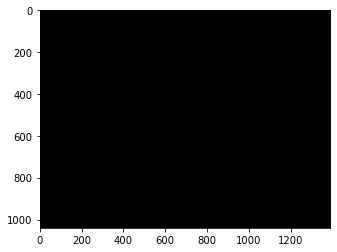

2


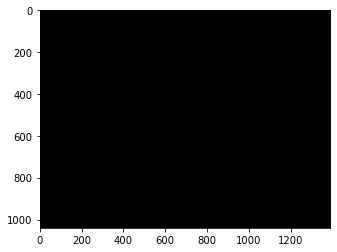

2


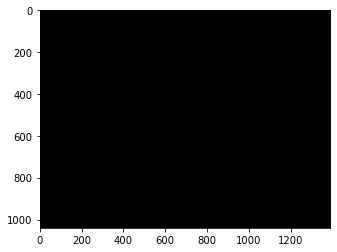

2


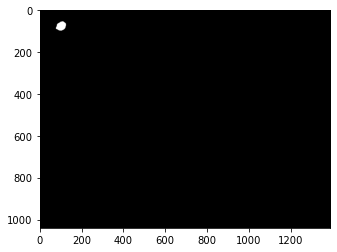

2


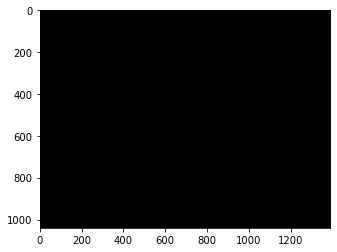

2


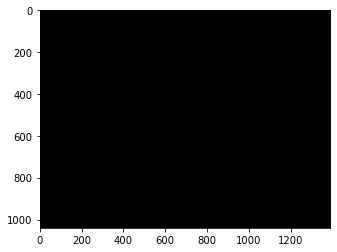

2


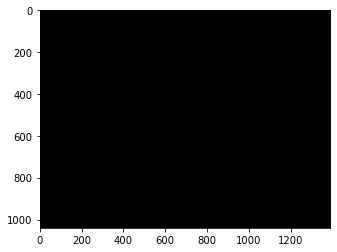

2


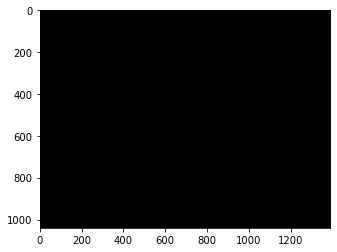

2


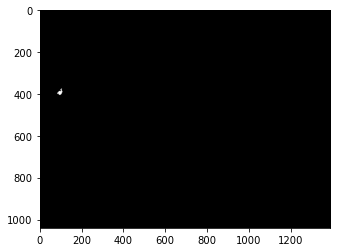

2


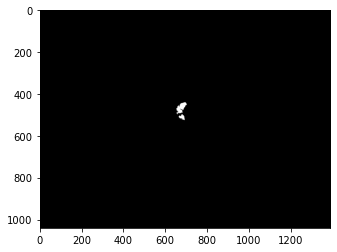

2


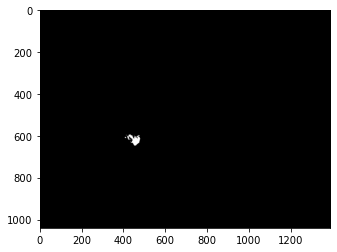

2


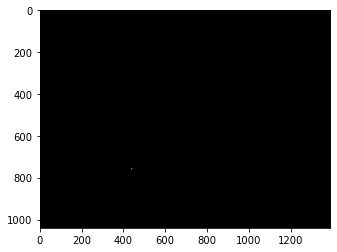

2


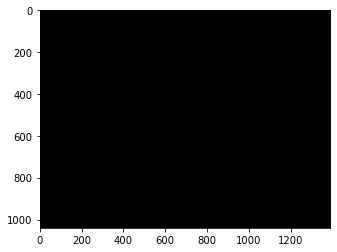

2


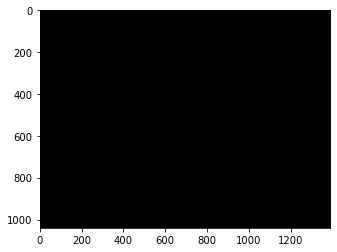

2


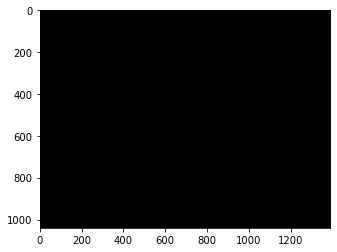

2


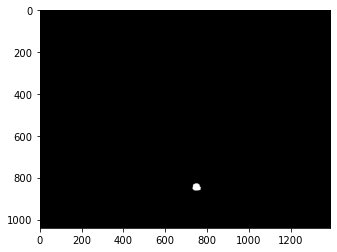

2


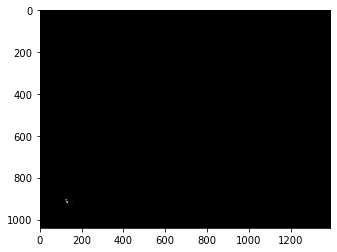

2


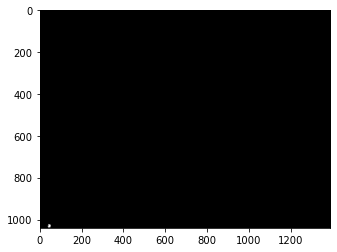

2


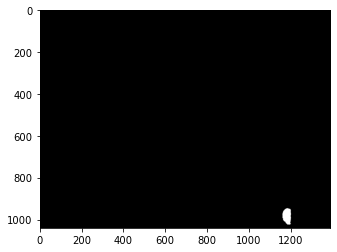

2


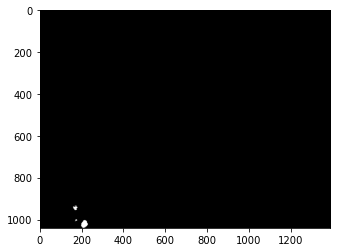

2


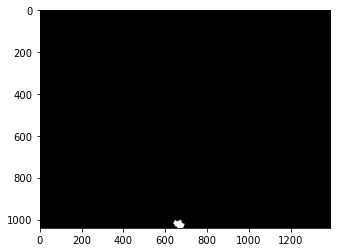

2


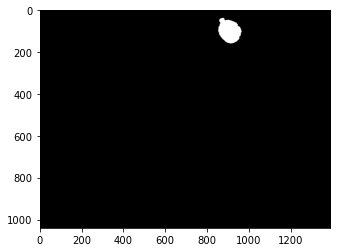

2


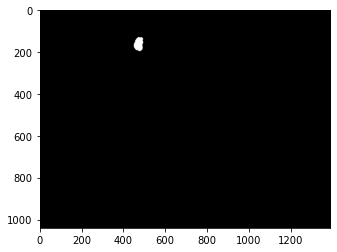

2


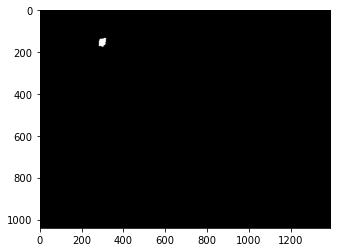

2


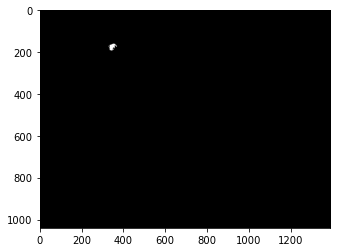

2


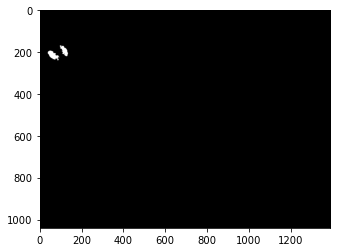

2


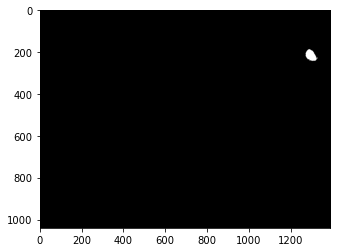

2


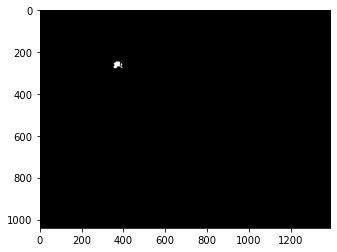

2


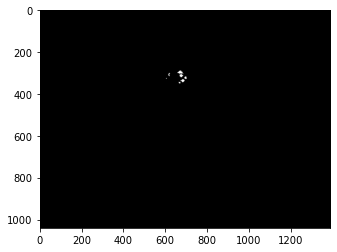

2


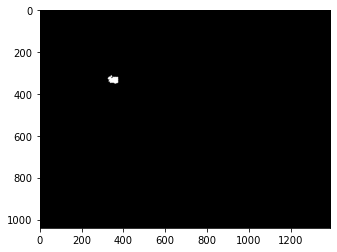

2


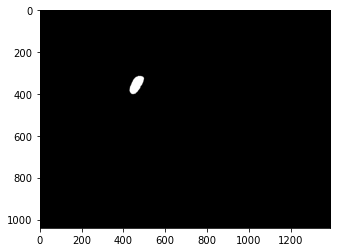

2


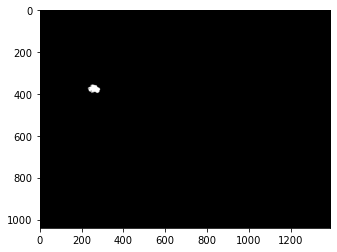

2


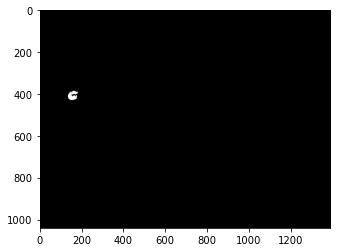

2


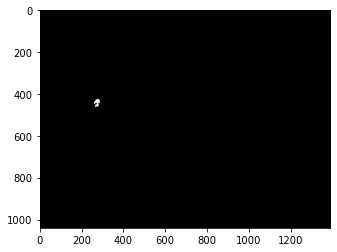

2


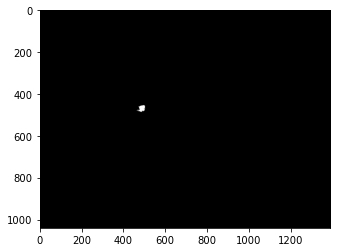

2


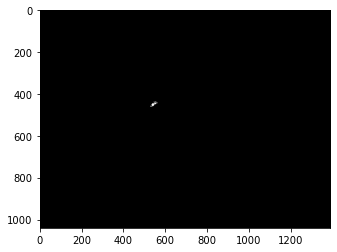

2


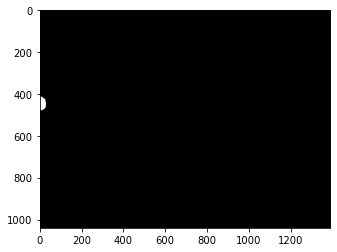

2


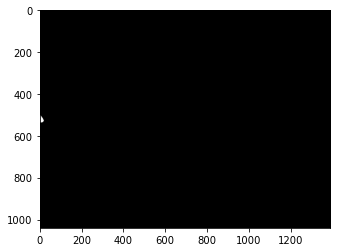

2


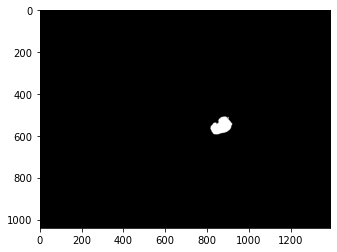

2


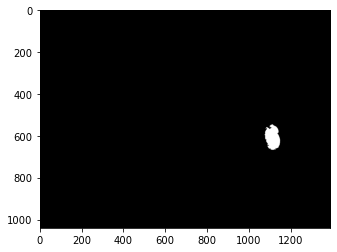

2


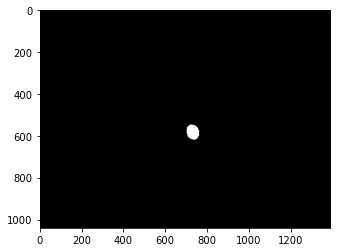

2


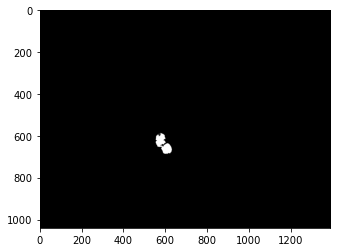

2


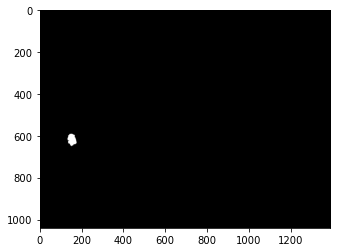

2


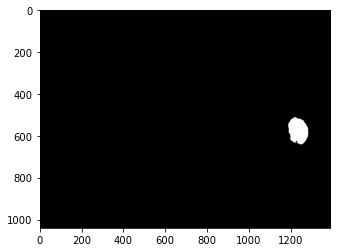

2


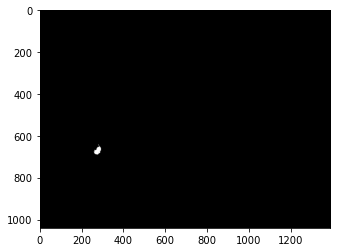

2


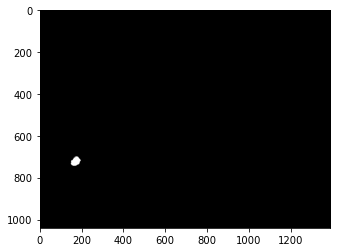

2


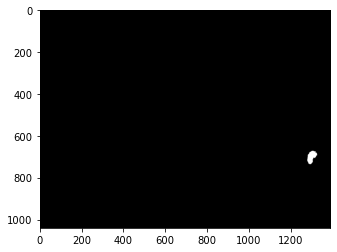

2


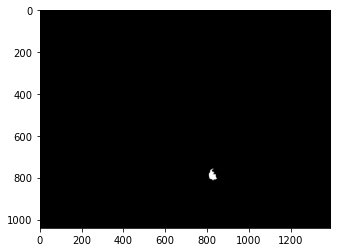

2


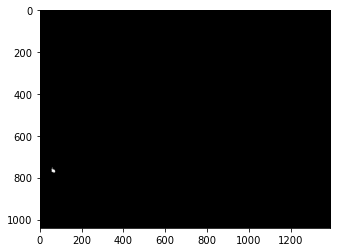

2


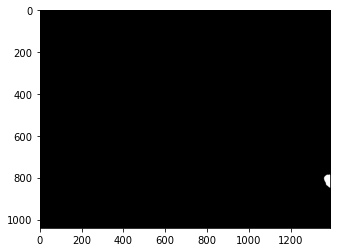

2


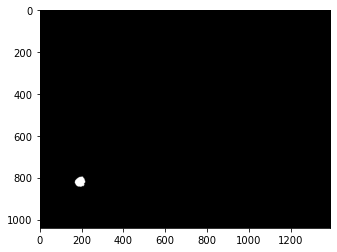

2


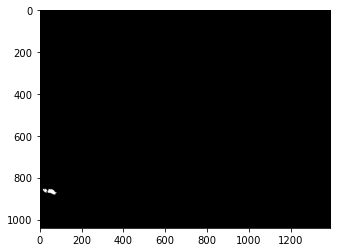

2


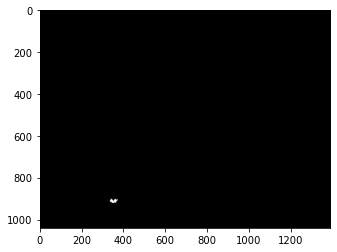

2


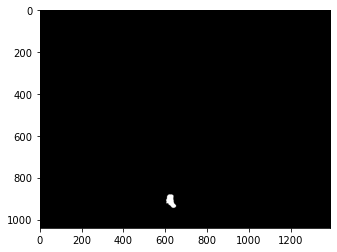

2


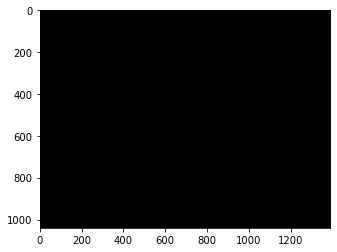

2


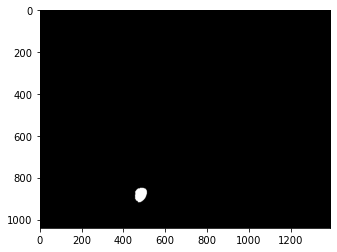

2


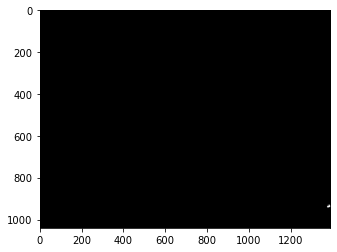

2


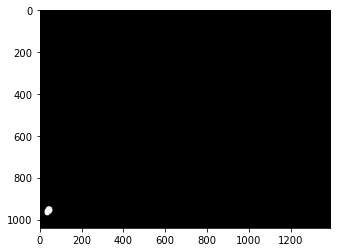

2


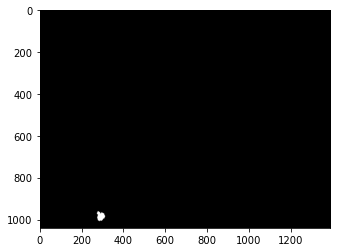

2


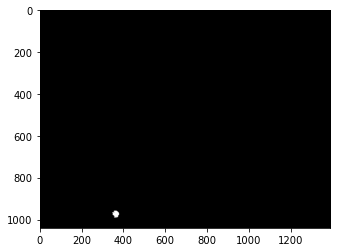

2


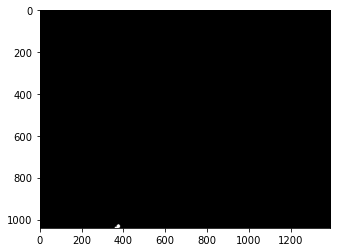

2


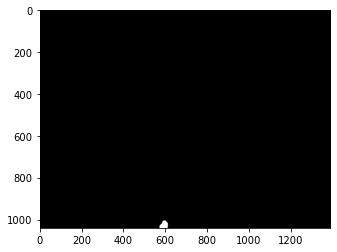

2


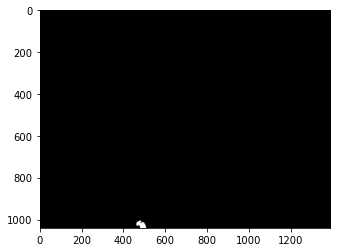

2


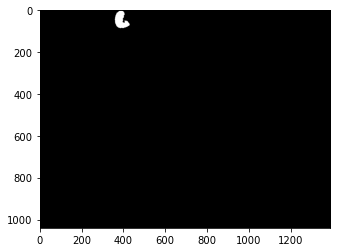

2


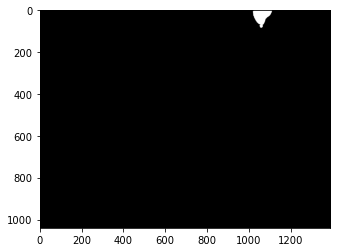

2


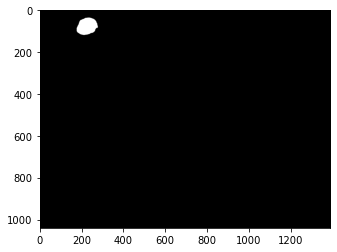

2


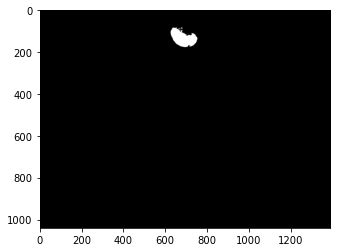

2


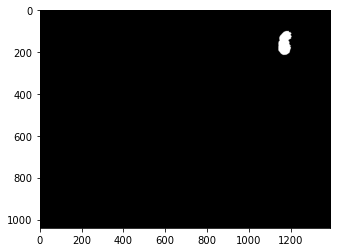

2


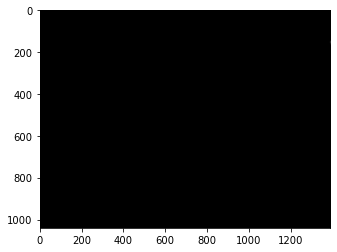

2


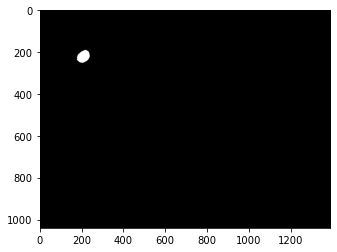

2


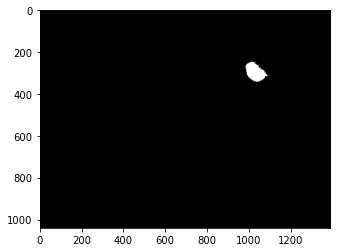

2


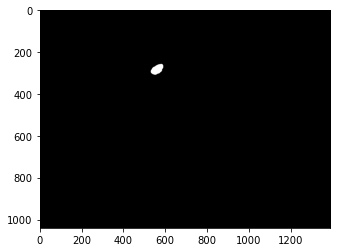

2


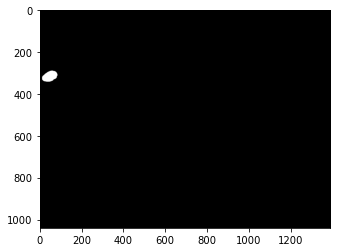

2


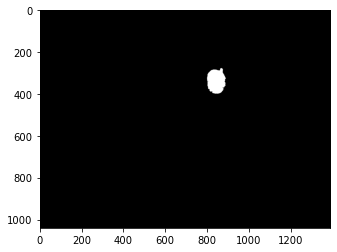

2


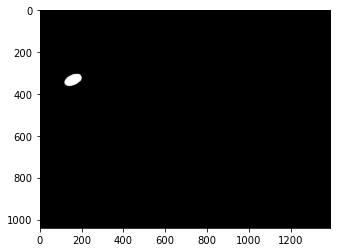

2


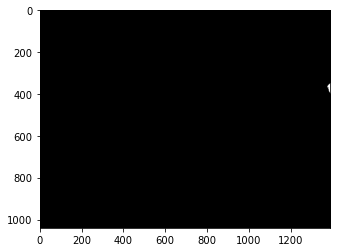

2


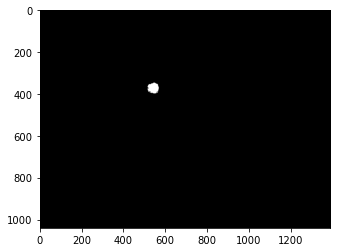

2


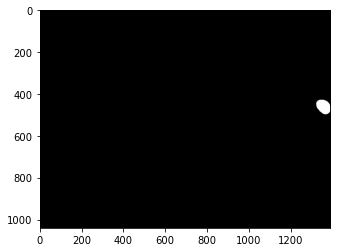

2


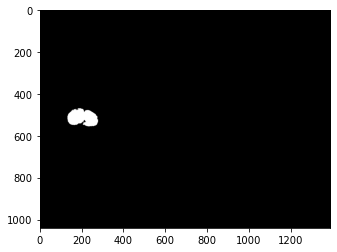

2


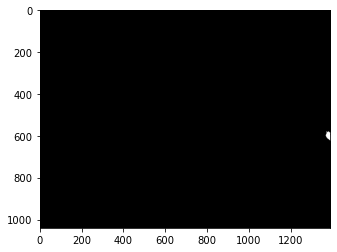

2


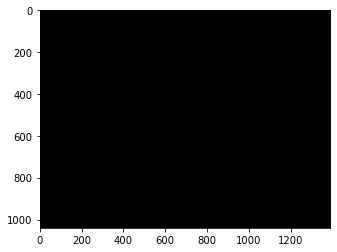

2


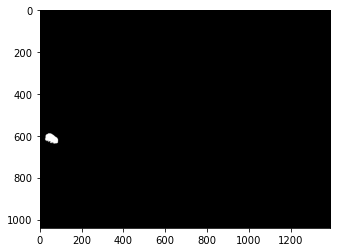

2


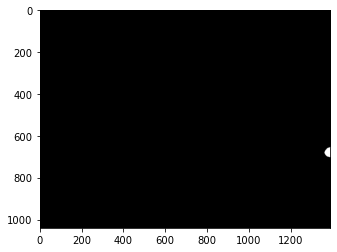

2


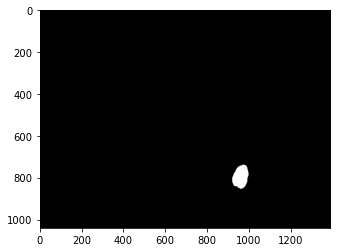

2


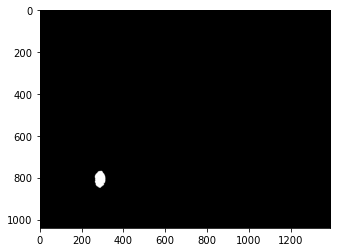

2


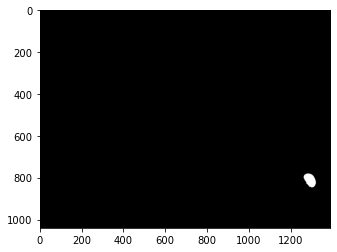

2


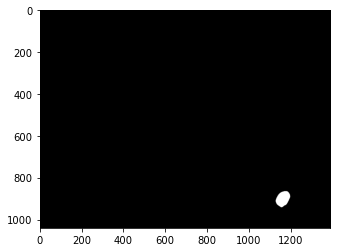

2


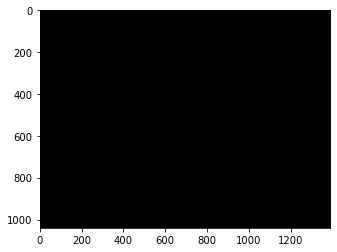

2


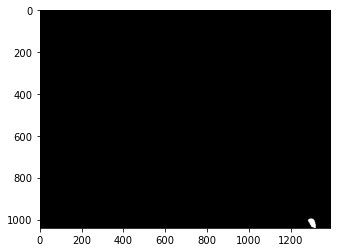

2


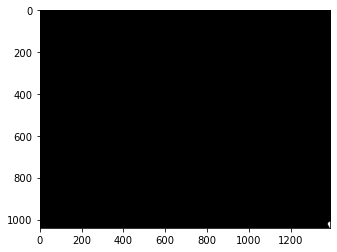

2


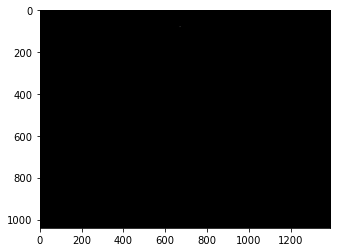

2


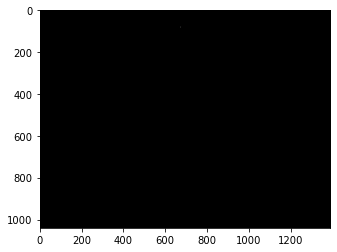

2


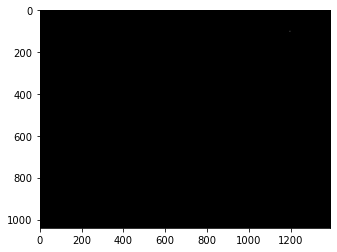

2


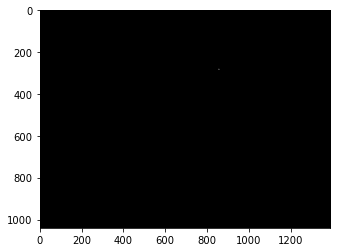

2


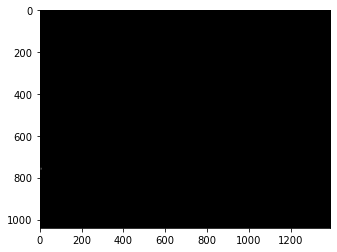

2


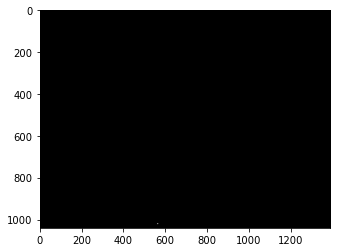

2


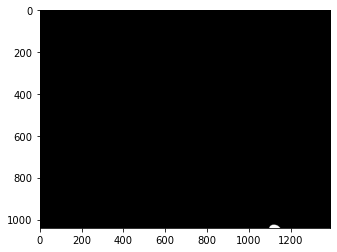

2


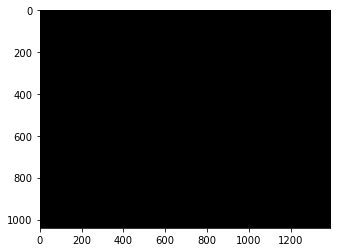

In [39]:
for l in np.unique(res):
    t = res == l
    t = t*l
    plt.figure()
    plt.imshow(t[8],cmap='gray')
    print(len(np.where(t[9] == l)))
    plt.show()

In [14]:
np.max(np.where(imagem>0)[0]) - np.min(np.where(imagem>0)[0])

5

In [ ]:
def nuclei_preprocessing(image,label,imgtype,thr,plot):
    global fill_temp,dil_fill
    # image = grayscale nuclei image
    # thr   = [otsu, contour area, dilation]
    
    from skimage.morphology import disk, binary_dilation
    img = copy.deepcopy(image)

    # Image > Otsu
    thresh_ori = threshold_otsu(img)
    binary_ori = img > thresh_ori*thr[0]
    image_     = binary_ori * img

    # Get nuclei contours
    contour, hierarchy = cv2.findContours(image_.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

    # Analyse each contour
    add_contours = []
    dil_contours = []
    centroids    = []
    for cnt in contour:
        cr = cnt.reshape((cnt.shape[0],cnt.shape[2]))
        
        # Remove nuclei close to walls
        ext = [min(cr[:,1]),max(cr[:,1]),min(cr[:,0]),max(cr[:,0])]
        if 0 in ext or 1 in ext or 2 in ext or 1040 in ext or 1039 in ext or 1038 in ext or 1388 in ext or 1387 in ext or 1386 in ext:
            continue
            
        # Size filter
        if cv2.contourArea(cnt) >= thr[1]:
            # Create image with contour
            fill_temp = np.zeros_like(image)
            cv2.fillPoly(fill_temp, pts = [cnt], color=(255,255,255))
            
            # Dilate previous image and get contour
            dil_fill = binary_dilation(fill_temp, disk(thr[2], dtype=bool))
            contour_dil, hierarchy_dil = cv2.findContours((dil_fill*1).astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

            # Get centroid of contour
            props    = regionprops(dil_fill*1,dil_fill*1)
            centroid = props[0].centroid 
            centroids.append(centroid)
            
            # Add contours to list
            add_contours.append(cnt)
            dil_contours.append(contour_dil[0])

    # Get nuclei masks
    fillcontours = np.zeros_like(image)
    cv2.fillPoly(fillcontours, pts = add_contours, color=(255,255,255))
    dilcontours = np.zeros_like(image)
    cv2.fillPoly(dilcontours, pts = dil_contours, color=(255,255,255))

    # Result 
    res = (dilcontours/255).astype(np.uint8) * img

    if plot:
        plt.figure(figsize=(12,12))
        plt.imshow(image,cmap='gray')
        plt.show()
        plt.figure(figsize=(12,12))
        plt.imshow(fillcontours,cmap='gray')
        plt.show()
        plt.figure(figsize=(12,12))
        plt.imshow(dilcontours,cmap='gray')
        plt.show()
        plt.figure(figsize=(12,12))
        plt.imshow(res,cmap='gray')
        for cx,cy in centroids:
            plt.plot(cy,cx,'o',color='red',markersize=7)
    
        plt.show()
        
    return dil_contours,centroids,res

print('FUNCTION: nuclei_preprocessing')

In [ ]:
[1.2,1.4,1.4,1.6,1.4,1.1,1.4,1.3,1,1,1.25,1.3,1.25,1.1,0.6,1.4,0.5]
[0.7,1.1,1.0,1.3,1.4,1.1,1.4,1.3,1,1,1.25,1.3,1.25,1.1,0.6,1.4,0.5]
[0.2,0.2,0.2,0.2,0.2,0.3,0.2,0.35,0.2,0.3,0.2,0.2,0.25,0.2,0.2,0.1,0.3,0.2]

In [38]:
len(X)

54

In [21]:
for a,b in enumerate(list_dir):
    print(a,b)

0 11_6IF_CHO_L_w3z_decon_ch00.tif
1 11_6IF_CHO_L_w3z_decon_ch01.tif
2 11_6IF_CHO_L_w3z_decon_ch02.tif
3 16_IF6_CHO_L-W1_Z_decon_ch00.tif
4 16_IF6_CHO_L-W1_Z_decon_ch01.tif
5 16_IF6_CHO_L-W1_Z_decon_ch02.tif
6 18_IF6_CHO_L-W1_Z_decon_ch00.tif
7 18_IF6_CHO_L-W1_Z_decon_ch01.tif
8 18_IF6_CHO_L-W1_Z_decon_ch02.tif
9 20_IF6_CHO_L-W1_Z_decon_ch00.tif
10 20_IF6_CHO_L-W1_Z_decon_ch01.tif
11 20_IF6_CHO_L-W1_Z_decon_ch02.tif
12 30_IF6_CHO_L-W3_Z_decon_ch00.tif
13 30_IF6_CHO_L-W3_Z_decon_ch01.tif
14 30_IF6_CHO_L-W3_Z_decon_ch02.tif
15 34_IF6_CHO_L-W5_Z_decon_ch00.tif
16 34_IF6_CHO_L-W5_Z_decon_ch01.tif
17 34_IF6_CHO_L-W5_Z_decon_ch02.tif
18 36_IF6_CHO_L-W5_Z_decon_ch00.tif
19 36_IF6_CHO_L-W5_Z_decon_ch01.tif
20 36_IF6_CHO_L-W5_Z_decon_ch02.tif
21 38_IF6_CHO_L-W5_Z_decon_ch00.tif
22 38_IF6_CHO_L-W5_Z_decon_ch01.tif
23 38_IF6_CHO_L-W5_Z_decon_ch02.tif
24 40_IF6_CHO_L-W6_Z_decon_ch00.tif
25 40_IF6_CHO_L-W6_Z_decon_ch01.tif
26 40_IF6_CHO_L-W6_Z_decon_ch02.tif
27 42_IF6_CHO_L-W6_Z_decon_ch00.tif
28 42

In [12]:
# Directories
dir_nucldec = os.getcwd() + "\\Datasets\\10Z" 
dir_masks   = os.getcwd() + '\\Datasets\\exps'
k           = [0.2,0.2,0.2,0.2,0.2,0.3,0.2,0.35,0.2,0.3,0.2,0.2,0.25,0.2,0.2,0.1,0.3,0.2]
volthr      = 1500


def 
# Imports
from glob import glob
from tifffile import imread, imwrite
from csbdeep.utils import2 Path, normalize
from csbdeep.io import save_tiff_imagej_compatible
from stardist import random_label_cmap, _draw_polygons, export_imagej_rois
from stardist.models import StarDist2D
from stardist.models import StarDist3D
from skimage.filters import threshold_otsu
from skimage.exposure import equalize_adapthist
from scipy import ndimage
from skimage.measure import label
from skimage.morphology import disk, binary_dilation

# Read all images
X        = sorted(glob(dir_nucldec + '\\*.tif')) # OR *.tiff!!
X        = list(map(imread,X))
list_dir = sorted(os.listdir(dir_nucldec))
count = 0

for img_id in range(0,len(X)):
    if list_dir[img_id].split('_')[-1] == 'ch00.tif':
        print(list_dir[img_id])
        temp   = X[img_id]
        thresh = threshold_otsu(temp)
        binary = temp > thresh*k[count]
        imagem = binary * temp

        copi = copy.deepcopy(imagem)

        # For each slice
        for sl in range(len(imagem)):
            # Contour Detection of slice sl
            contours, hierarchy = cv2.findContours(imagem[sl].astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)  

            # Draw contours and 
            contour_int = np.zeros_like(imagem[sl])
            cv2.fillPoly(contour_int, pts = contours, color=(255,255,255))
            copi[sl] = contour_int

#             # Filter contours with area above certain threshold
#             # Analyse each contour
#             add_contours = []
#             dil_contours = []
#             centroids    = []

#             filt_contours = []
#             remo_contours = []
#             for contour in contours:
#                 if len(contour) <= 3:
#                     remo_contours.append(contour)
#                 else:
#                     filt_contours.append(contour)

#             removed_out = np.zeros_like(imagem[i])
#             contour_int = np.zeros_like(imagem[i])
#             cv2.fillPoly(removed_out, pts = remo_contours, color=(255,255,255))
#             cv2.fillPoly(contour_int, pts = filt_contours, color=(255,255,255))

#             copi[i] = contour_int
            #plt.figure()
            #plt.imshow(contour_int,cmap='gray')

        res = label(copi)
        break

        # Remove volumes with size < volthr and close to borders
        N_excluded = 0
        for vol_id in np.unique(res)[1:]:
            u = res == vol_id
            u = u*vol_id
            if len(np.where(u == vol_id)[0]) < volthr or excludeborder(u) == True:
                N_excluded += 1
                res = res - u
        print("Number of excluded nuclei: " + str(N_excluded))

        count += 1
        imwrite(os.path.join(dir_masks, list_dir[img_id]), np.array(res,dtype=np.uint8),photometric='minisblack')




# Segmentation
#imi = segment_patches_3D(dir_nucldec, dir_masks)

# print('🌠')

70_IF6_CHO_L-W8_Z_decon_ch00.tif


In [ ]:
# Directories
dir_nucldec = os.getcwd() + "\\Datasets\\10Z" 
dir_masks   = os.getcwd() + '\\Datasets\\exps'
k           = [0.2,0.2,0.2,0.2,0.2,0.3,0.2,0.35,0.2,0.3,0.2,0.2,0.25,0.2,0.2,0.1,0.3,0.2]
volthr      = 1500



# Imports
from glob import glob
from tifffile import imread, imwrite
from csbdeep.utils import Path, normalize
from csbdeep.io import save_tiff_imagej_compatible
from stardist import random_label_cmap, _draw_polygons, export_imagej_rois
from stardist.models import StarDist2D
from stardist.models import StarDist3D
from skimage.filters import threshold_otsu
from skimage.exposure import equalize_adapthist
from scipy import ndimage
from skimage.measure import label
from skimage.morphology import disk, binary_dilation
from skimage.segmentation import watershed
from skimage.feature import peak_local_max

# Read all images
X        = sorted(glob(dir_nucldec + '\\*.tif')) # OR *.tiff!!
X        = list(map(imread,X))
list_dir = sorted(os.listdir(dir_nucldec))
count = 0

for img_id in range(0,len(X)):
    
    if list_dir[img_id].split('_')[-1] == 'ch00.tif':
        print(list_dir[img_id])
        temp   = X[img_id]
        thresh = threshold_otsu(temp)
        binary = temp > thresh*k[count]
        imagem = binary * temp

        distance = ndimage.distance_transform_edt(imagem)
        coords = peak_local_max(distance, footprint=np.ones((3, 3)), labels=imagem)
        mask = np.zeros(distance.shape, dtype=bool)
        mask[tuple(coords.T)] = True
        markers, _ = label(mask)
        labels = watershed(-distance, markers, mask=imagem)
        res = labels
        
        break
        copi = copy.deepcopy(imagem)

#         # For each slice
#         for sl in range(len(imagem)):
#             # Contour Detection of slice sl
#             contours, hierarchy = cv2.findContours(imagem[sl].astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)  

#             # Draw contours and 
#             contour_int = np.zeros_like(imagem[sl])
#             cv2.fillPoly(contour_int, pts = contours, color=(255,255,255))
#             copi[sl] = contour_int

#             # Filter contours with area above certain threshold
#             # Analyse each contour
#             add_contours = []
#             dil_contours = []
#             centroids    = []

#             filt_contours = []
#             remo_contours = []
#             for contour in contours:
#                 if len(contour) <= 3:
#                     remo_contours.append(contour)
#                 else:
#                     filt_contours.append(contour)

#             removed_out = np.zeros_like(imagem[i])
#             contour_int = np.zeros_like(imagem[i])
#             cv2.fillPoly(removed_out, pts = remo_contours, color=(255,255,255))
#             cv2.fillPoly(contour_int, pts = filt_contours, color=(255,255,255))

#             copi[i] = contour_int
            #plt.figure()
            #plt.imshow(contour_int,cmap='gray')

        res = label(copi)

        # Remove volumes with size < volthr and close to borders
        for vol_id in np.unique(res)[1:]:
            u = res == vol_id
            u = u*vol_id
            if len(np.where(u == vol_id)[0]) < volthr or excludeborder(u) == True:
                print('excluded')
                res = res - u
        
        count += 1
        imwrite(os.path.join(dir_masks, list_dir[img_id]), np.array(res,dtype=np.uint8),photometric='minisblack')
        



# Segmentation
#imi = segment_patches_3D(dir_nucldec, dir_masks)

# print('🌠')

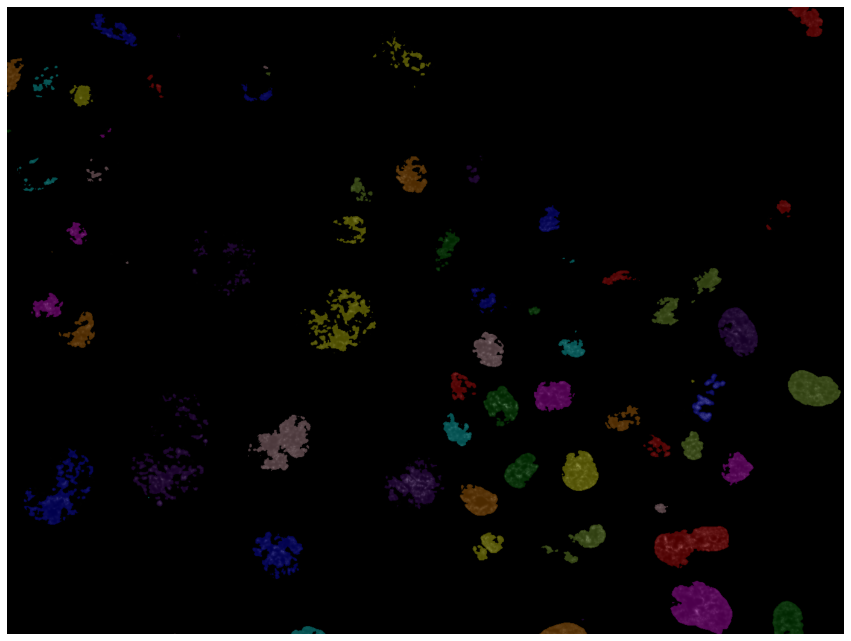

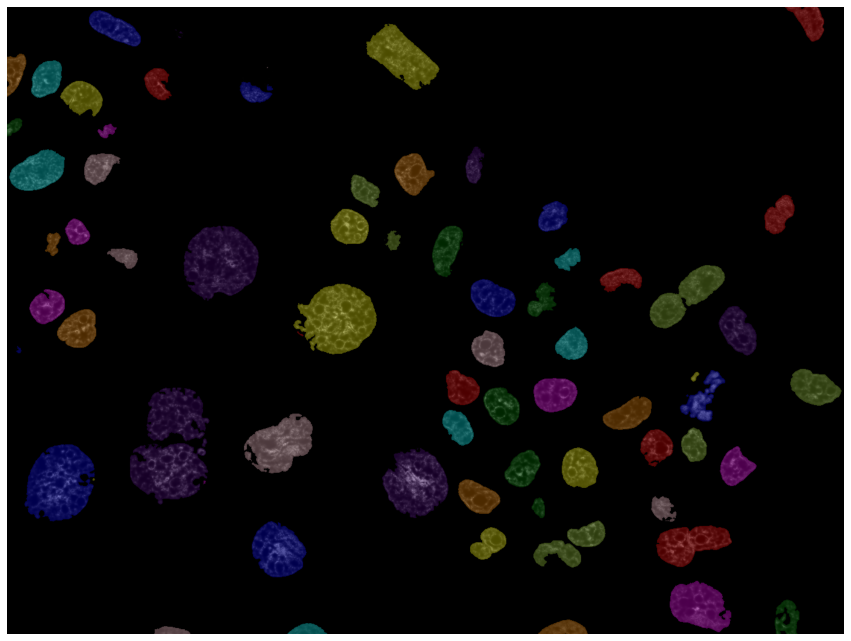

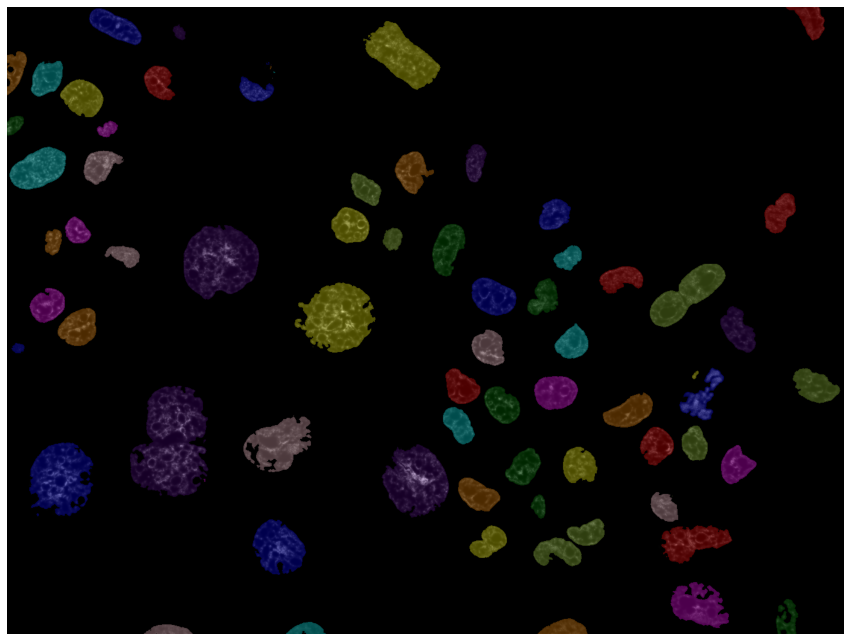

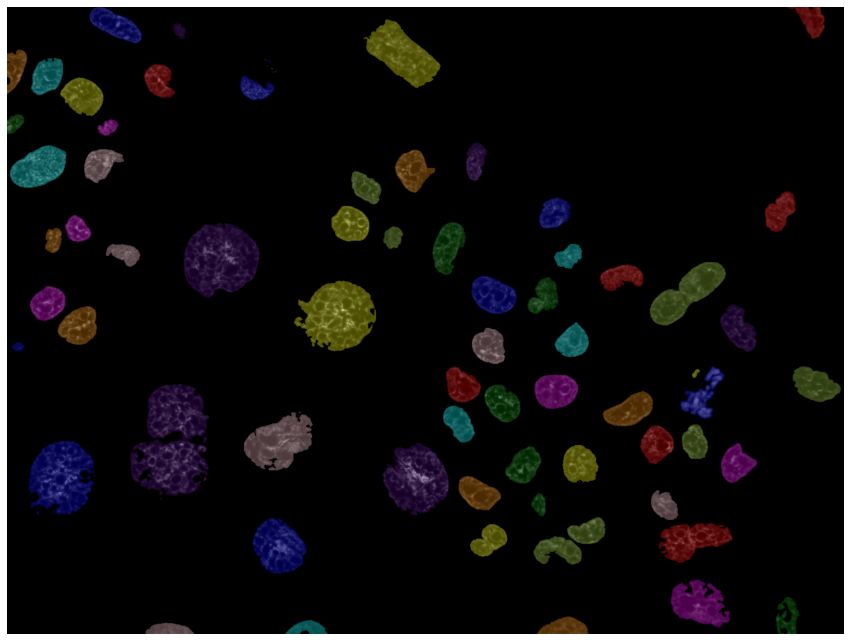

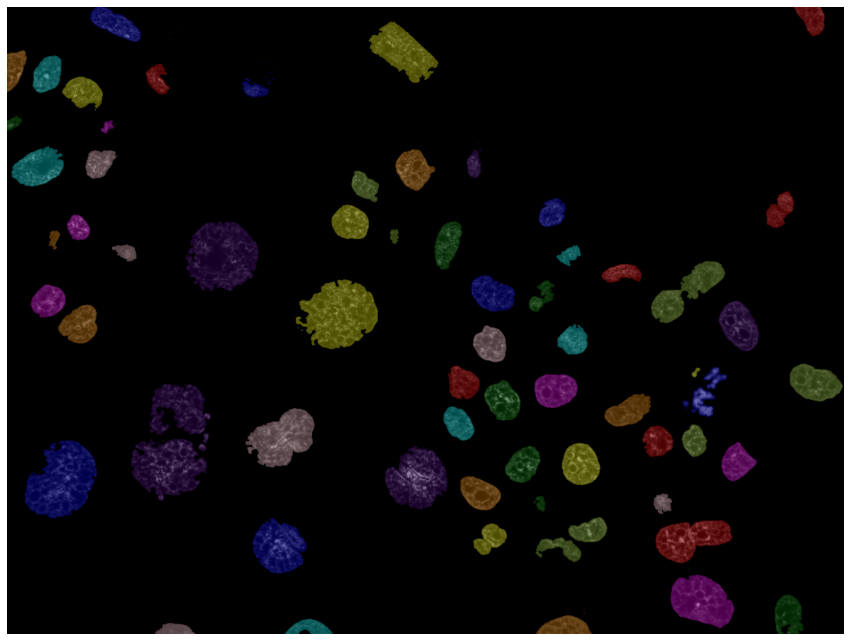

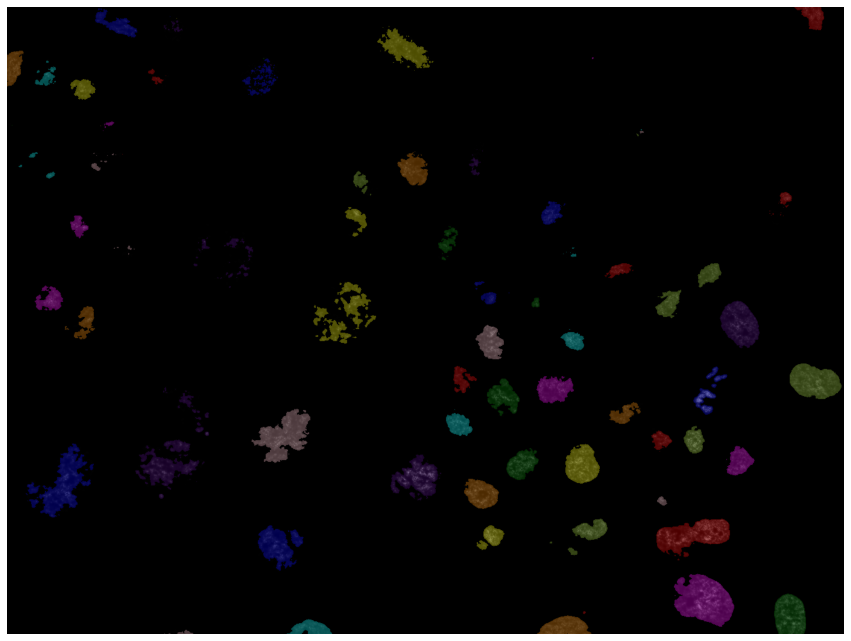

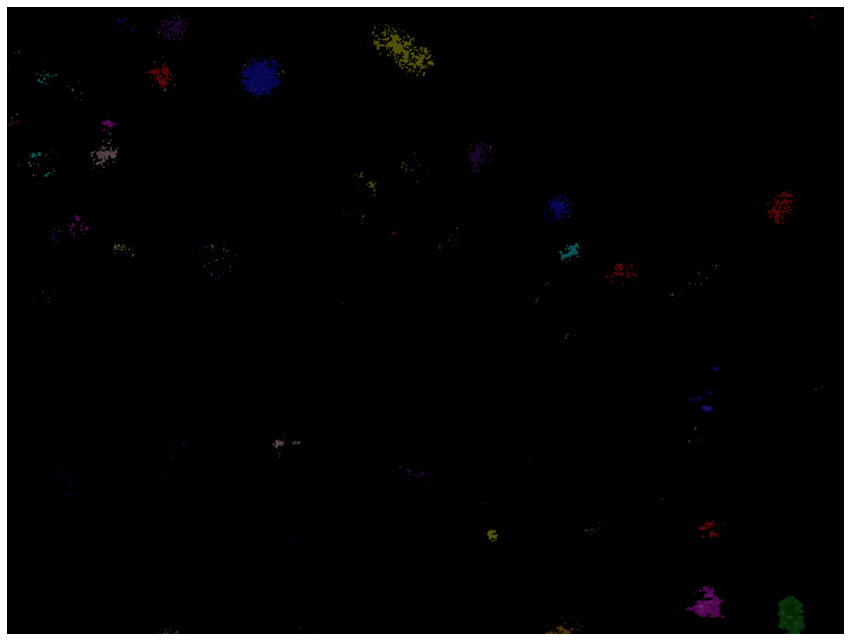

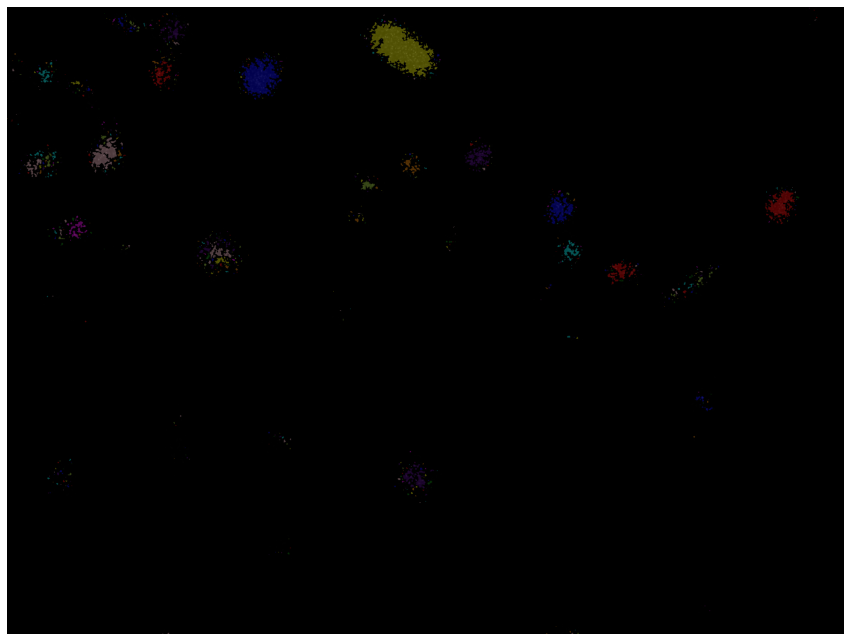

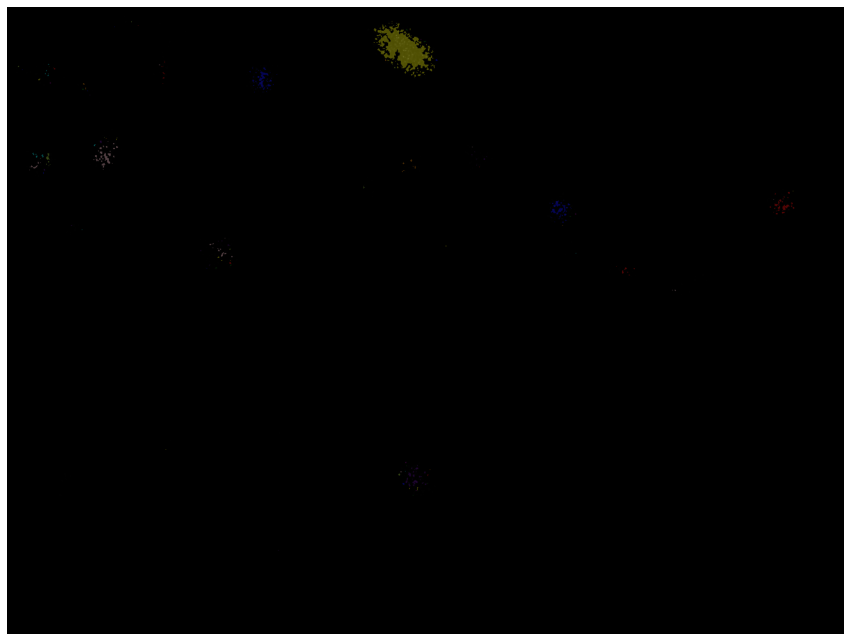

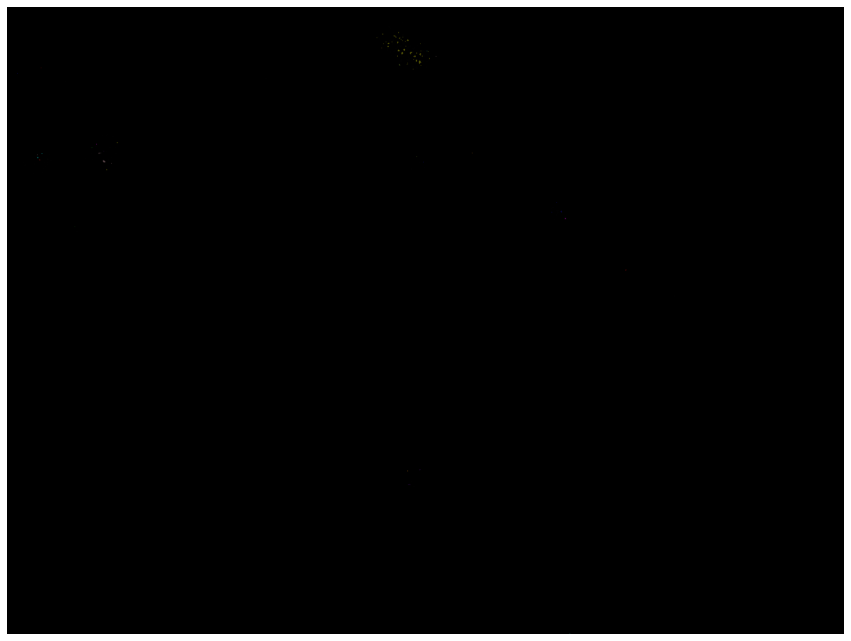

In [16]:
from skimage.color import label2rgb
test = label2rgb(res, image=temp, bg_label=0)
sl = 1
for im in test:
    plt.figure(figsize=(15,15))
    plt.axis('off')
    plt.imshow(im)
    #plt.savefig("..//tempp//id70_slice" + str(sl) + ".png",format='png',transparent=True,bbox_inches='tight',dpi=200)
    plt.show()  
    sl += 1

In [3]:
# Directories
dir_nucldec = os.getcwd() + "\\Datasets\\10Z" 
dir_masks   = os.getcwd() + '\\Datasets\\exps'

# Imports
from glob import glob
from tifffile import imread, imwrite
from csbdeep.utils import Path, normalize
from csbdeep.io import save_tiff_imagej_compatible
from stardist import random_label_cmap, _draw_polygons, export_imagej_rois
from stardist.models import StarDist2D
from stardist.models import StarDist3D
from skimage.filters import threshold_otsu
from skimage.exposure import equalize_adapthist
from scipy import ndimage

# Read all images
X = sorted(glob(dir_nucldec + '\\*.tif')) # OR *.tiff!!
X = list(map(imread,X))
list_dir = sorted(os.listdir(dir_nucldec))
grid = [[row, col] for row in np.linspace(0.7,0.8,5) for col in np.linspace(0.3,0.4,2)]
model = StarDist3D.from_pretrained('3D_demo')
for ii in range(0,len(X)):
    if list_dir[ii].split('_')[-1] == 'ch00.tif':
        temp = X[ii]
        #g    = gaussian_filter(temp, sigma=1)
        #a = equalize_adapthist(g)
        #thresh = threshold_otsu(a)
        #binary = a > thresh*0.3
        
        #imagem = binary *1

            
        #temp_ = temp * binary
        
        
        #temp_ = equalize_adapthist(temp_)
        #temp_ = temp
        img = normalize(temp, 1,99.8, axis=(0,1,2))
        #img_ = resample_mine(img,0.5)
        img_ = img
#             for i,j in grid:
#                 print(i,j)
        labels, details = model.predict_instances(img_,prob_thresh=0.75,nms_thresh=0.3,verbose=True)
        break
        imwrite(os.path.join(dir_masks, list_dir[ii]), labels,photometric='minisblack')
        
            


# Segmentation
#imi = segment_patches_3D(dir_nucldec, dir_masks)

# print('🌠')

Found model '3D_demo' for 'StarDist3D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.707933, nms_thresh=0.3.
predicting instances with nms_thresh = 0.3
non-maximum suppression...
NMS took 0.6267 s
keeping 63/143 polyhedra
render polygons...


# <font color='red'>2.4 Nuclei Processing</font>

In [ ]:
from tifffile import imread, imwrite
from stardist.models import StarDist3D
from csbdeep.utils import normalize
from stardist.geometry import dist_to_coord3D
import napari
#def process3Dnuclei(dir_masks):
dir_masks = os.getcwd() + '\\Datasets\\10Z_nuc_masks'
for img in os.listdir(dir_masks):
    # Get image
    path     = dir_masks + '/' + img
    nuc_mask = imread(path)
    idx = int(img.split('_')[0])
    df = TenDF[TenDF['Channel'] == 0]
    # Initialize DataFrame to put the Centroids in:
    #isolated_nucleus = pd.DataFrame(columns=['ID','Mask With ID','Centroid','Contour'])

    if idx == 9:
        # Obtain isolated nucleus
        for nucleus in np.unique(nuc_mask):
            if nucleus != 0: #Not background

                try:
                    # Obtain isolated nucleus
                    aux  = nuc_mask == nucleus
                    mask_w_id = aux*nuc_mask
                    bin_nuclei = np.where(mask_w_id>0.5, 1, 0)
                    im = (df['Image'][idx] * bin_nuclei) / np.max(df['Image'][idx])


                    #print(bin_nuclei.shape,np.unique(bin_nuclei))

                    feats_all_n                      = ImageFeatures((im *255).astype(np.uint8))
                    feats_labels_n_, feats_values_n_ = feats_all_n.print_features(print_values = False)
                    feats_labels_n_, feats_values_n_ = remove_not1D(feats_labels_n_,feats_values_n_)
                    feats_labels_n_                  = ['DNF:' + ftn for ftn in feats_labels_n_]

                    if 'nucDF' not in globals():
                        global nucDF
                        nucDF = pd.DataFrame(columns = ['Img Index'] + ['Label'] + ['ID'] + list(feats_labels_n_))
                    new   = pd.Series([int(idx)] + [df['Label'][idx]] + [int(nucleus)] + feats_values_n_,index=nucDF.columns)
                    nucDF = nucDF.append(new,ignore_index=True)
                except:
                    print('error')
                    pass


#process3Dnuclei(os.getcwd() + '\\Datasets\\10Znuc')

_regionprops.py (395): Failed to get convex hull image. Returning empty image, see error message below:
QH6013 qhull input error: input is less than 3-dimensional since all points have the same x coordinate    0

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 536799151  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _max-width  3  Error-roundoff 4.2e-15  _one-merge 2.9e-14
  _near-inside 1.5e-13  Visible-distance 8.3e-15  U-max-coplanar 8.3e-15
  Width-outside 1.7e-14  _wide-facet 5e-14  _maxoutside 3.3e-14

_regionprops.py (577): divide by zero encountered in long_scalars
_regionprops.py (395): Failed to get convex hull image. Returning empty image, see error message below:
QH6013 qhull input error: input is less than 3-dimensional since all points have the same x coordinate    0

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 536899993  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _max-wid

error


In [16]:
nucDF

,Img Index,Label,ID,DNF:Area,DNF:BB Area,DNF:Perimeter,DNF:Area convex,DNF:Centroid Divergence,DNF:Equivalent Diameter,DNF:Extent,...,DNF:Std,DNF:Variance,DNF:Skewness,DNF:Kurtosis,DNF:Contrast,DNF:Max Intensity,DNF:Min Intensity,DNF:Entropy,DNF:Inertia Tensor Highest Eigenvalue,DNF:Inertia Tensor Lowest Eigenvalue
0,9,WT,1,1730,4320,0,2648,4.670547,14.894154,0.400463,...,39.138753,1531.841947,1.484791,2.370019,9.410554,209.0,1.0,0.002549,142.546001,91.169854
1,9,WT,2,466,1716,0,686,0.772976,9.618982,0.271562,...,52.258391,2730.939398,1.006686,0.318160,2.761152,221.0,1.0,0.000747,59.529103,40.668704
2,9,WT,3,1603,2436,0,1751,3.135378,14.520391,0.658046,...,33.381423,1114.319432,2.194921,7.076820,10.457777,236.0,1.0,0.002333,94.034187,62.179963
3,9,WT,4,950,2208,0,1229,1.015400,12.196681,0.430254,...,36.493909,1331.805430,1.209267,2.519765,5.600157,255.0,1.0,0.001447,50.239695,31.010885
4,9,WT,5,590,1596,0,812,0.658348,10.406015,0.369674,...,25.695222,660.244438,1.098961,1.740339,4.220594,175.0,1.0,0.000908,35.552809,25.553467
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105,9,WT,113,455,880,0,559,0.783022,9.542692,0.517045,...,23.344025,544.943480,0.976667,1.016380,3.133930,138.0,2.0,0.000712,41.130396,23.645044
106,9,WT,114,341,532,0,377,0.977600,8.667994,0.640977,...,17.284733,298.761982,0.945368,0.017629,3.366179,73.0,1.0,0.000526,29.941905,19.984073
107,9,WT,115,334,765,0,435,0.797388,8.608271,0.436601,...,27.100859,734.456569,1.354997,1.441215,2.589216,140.0,1.0,0.000530,27.219280,17.407543
108,9,WT,116,708,1008,0,763,0.846122,11.058041,0.702381,...,14.250810,203.085582,1.158856,1.986136,6.538330,109.0,1.0,0.001046,60.356916,39.894502


In [7]:
AQUI

11
16
18
20
30
34
36
38
40
42
44
59
63
66
70
72
74
9


In [12]:
nucDF['DNF:Height'][0]

array([    0,     1,     2, ..., 15245, 15246, 15247], dtype=int64)

In [29]:
imgg[min(bin_nuclei_[0]):max(bin_nuclei_[0]),min(bin_nuclei_[1]):max(bin_nuclei_[1]),min(bin_nuclei_[2]):max(bin_nuclei_[2])]

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [38]:
np.where(bin_nuclei_>0)

(array([5, 5, 5, ..., 9, 9, 9], dtype=int64),
 array([352, 352, 352, ..., 312, 326, 341], dtype=int64),
 array([851, 852, 853, ..., 833, 867, 862], dtype=int64))

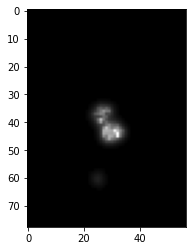

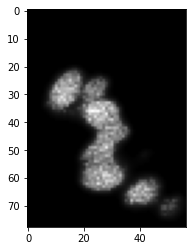

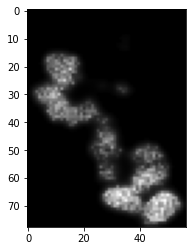

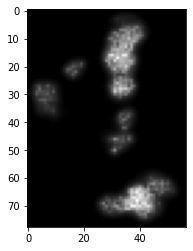

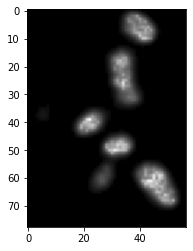

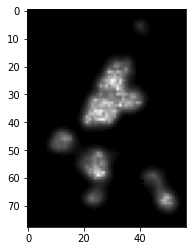

In [12]:
idn = 0
for slic in nucDF['Image'][6]:
    plt.figure()
    plt.imshow(slic,cmap='gray')
    plt.show()

In [9]:
!python setup.py install

running install
running build
running build_ext
building 'glcm' extension
creating build\temp.win-amd64-3.7\Release\py-glcm
creating build\temp.win-amd64-3.7\Release\py-glcm\core
creating build\temp.win-amd64-3.7\Release\py-glcm\core\src
C:\Program Files (x86)\Microsoft Visual Studio\2019\BuildTools\VC\Tools\MSVC\14.29.30133\bin\HostX86\x64\cl.exe /c /nologo /Ox /W3 /GL /DNDEBUG /MD -IC:\Users\diogo\anaconda3\envs\Cytoskeleton\lib\site-packages\numpy\core\include -IC:\Users\diogo\anaconda3\envs\Cytoskeleton\lib\site-packages\numpy\core\include -IC:\Users\diogo\anaconda3\envs\Cytoskeleton\include -IC:\Users\diogo\anaconda3\envs\Cytoskeleton\include "-IC:\Program Files (x86)\Microsoft Visual Studio\2019\BuildTools\VC\Tools\MSVC\14.29.30133\include" "-IC:\Program Files (x86)\Windows Kits\10\include\10.0.19041.0\ucrt" "-IC:\Program Files (x86)\Windows Kits\10\include\10.0.19041.0\shared" "-IC:\Program Files (x86)\Windows Kits\10\include\10.0.19041.0\um" "-IC:\Program Files (x86)\Windows Ki

In [11]:
copi.shape

NameError: name 'copi' is not defined

In [ ]:
glcm.xglcm(array, dists, dirs, mode, symmetric=True, bins=256, normalized=True, check=True)

In [29]:
GUARDAR

,Img Index,ID,Label,DNF:Area,DNF:BB Area,DNF:Perimeter,DNF:Area convex,DNF:Centroid Divergence,DNF:Equivalent Diameter,DNF:Extent,...,DNF:Std,DNF:Variance,DNF:Skewness,DNF:Kurtosis,DNF:Contrast,DNF:Max Intensity,DNF:Min Intensity,DNF:Entropy,DNF:Inertia Tensor Highest Eigenvalue,DNF:Inertia Tensor Lowest Eigenvalue
0,11,2,WT,15263,56875,0,25851,2.620436,30.776112,0.268360,...,36.575582,1337.773233,0.909176,0.969201,65.224679,255.0,1.0,0.019457,1343.323905,845.955932
1,11,12,WT,4265,13132,0,6520,0.684785,20.120563,0.324779,...,28.506079,812.596566,2.365222,9.504794,30.428543,255.0,3.0,0.005739,361.455282,254.410732
2,11,15,WT,11672,40290,0,18560,2.232251,28.143766,0.289700,...,35.516602,1261.429044,1.376357,1.842485,65.190099,255.0,1.0,0.014929,882.263082,598.587662
3,11,16,WT,10943,45675,0,18279,0.855664,27.545200,0.239584,...,26.850195,720.932978,1.686717,5.677823,65.691350,255.0,1.0,0.013884,990.226845,708.304786
4,11,35,WT,15753,51480,0,25041,2.049827,31.101993,0.306002,...,33.425979,1117.296093,1.173836,1.674896,78.236862,255.0,1.0,0.019803,1272.681290,979.821275
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1313,9,39,WT,16609,36456,0,22116,1.403224,31.655435,0.455590,...,35.039189,1227.744753,0.964467,0.959704,76.242193,255.0,2.0,0.020914,1283.470670,833.072764
1314,9,43,WT,16398,33276,0,21296,2.292643,31.520814,0.492788,...,26.971204,727.445821,1.682919,4.138719,105.131934,255.0,2.0,0.020060,1713.804346,1228.916043
1315,9,44,WT,7153,15150,0,9651,0.768022,23.905429,0.472145,...,38.891036,1512.512709,0.496625,0.118823,27.275083,255.0,3.0,0.009729,855.588487,616.947465
1316,9,47,WT,5811,10092,0,6775,0.290834,22.305780,0.575803,...,35.518280,1261.548242,0.917846,1.139019,26.458092,255.0,9.0,0.007935,620.557955,484.360502


## napari to see segmentation

In [14]:
# import image
from tifffile import imread, imwrite
from stardist.models import StarDist3D
from csbdeep.utils import Path, normalize
from stardist.geometry import dist_to_coord3D
import napari
image = imread(os.getcwd() + "\\Datasets\\10Z\\11_6IF_CHO_L_w3z_decon_ch00.tif" )

# import model
model = StarDist3D.from_pretrained('3D_demo')

# normalize image
img = normalize(image, 1,99.8, axis=(0,1,2))
img_ = downsample(img)
# predict segmentation
labels, details = model.predict_instances(img_)
labels_ = resample_mine(labels,2.0)

# calculate 3d coordinates from rays and distances
coord = dist_to_coord3D(details['dist'], details['points'], details['rays_vertices'])

# create list of colors to use randomly use for objects
colormaps = ['yellow', 'green', 'red','blue','cyan','magenta']
colors = np.random.choice(colormaps, len(coord))

# create napari viewer
viewer = napari.Viewer(ndisplay=3)
#viewer.add_image(image, blending = 'additive')
for i in range(len(coord)):
    # plot each object as a surface object
    vertices = coord[i,:,:]
    faces = details['rays_faces']
    values = np.linspace(0, 1, len(vertices))
    surface = (vertices, faces, values)
    viewer.add_surface(surface, colormap=colors[i], blending = 'translucent')

Found model '3D_demo' for 'StarDist3D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.707933, nms_thresh=0.3.


ValueError: could not broadcast input array from shape (1040,1388) into shape (260,347)

In [16]:
labels.shape

(10, 520, 694)

In [9]:
ls -a c:/users/diogo/anaconda3/envs/cytoskeleton/lib/site-packages | grep "^~"

Invalid switch - "users".


In [5]:
pip install napari -U

Note: you may need to restart the kernel to use updated packages.


In [ ]:
patch_n  = aux_n[min(cr[:,1]):max(cr[:,1]),min(cr[:,0]):max(cr[:,0])]
patch_n_norm = patch_n / np.max(aux_n)
feats_all_n                      = ImageFeatures((patch_n_norm *255).astype(np.uint8))
feats_labels_n_, feats_values_n_ = feats_all_n.print_features(print_values = False)
feats_labels_n_, feats_values_n_ = remove_not1D(feats_labels_n_,feats_values_n_)
feats_labels_n_                  = ['DNF:' + ftn for ftn in feats_labels_n_]

In [17]:
c = np.zeros((int(image.shape[0]),int(image.shape[1]/2),int(image.shape[2]/2)))
for i in range(len(image)):
    c[i] = scipy.ndimage.zoom(image[i], 0.5, order=0)

In [19]:
c.shape

(10, 520, 694)

In [7]:
scipy.ndimage.zoom(image, 0.5, order=0).shape

(5, 520, 694)

# <font color='red'>2.5 Plot Results</font>

In [1]:
import napari

viewer = napari.view_image(image)

NameError: name 'image' is not defined

In [6]:
np.max(image)

65535

In [3]:
# import image
from tifffile import imread, imwrite
from stardist.models import StarDist3D
from csbdeep.utils import Path, normalize
from stardist.geometry import dist_to_coord3D
import napari
image = imread(os.getcwd() + "\\Datasets\\10Z\\9_6IF_CHO_L_w3z_decon_ch00.tif" )

# import model
model = StarDist3D.from_pretrained('3D_demo')

# normalize image
img = normalize(image, 1,99.8, axis=(0,1,2))

# predict segmentation
labels, details = model.predict_instances(img)

# calculate 3d coordinates from rays and distances
coord = dist_to_coord3D(details['dist'], details['points'], details['rays_vertices'])

# create list of colors to use randomly use for objects
colormaps = ['yellow', 'green', 'red','blue','cyan','magenta']
colors = np.random.choice(colormaps, len(coord))

# create napari viewer
viewer = napari.Viewer(ndisplay=3)
viewer.add_image(image, blending = 'additive')
for i in range(len(coord)):
    # plot each object as a surface object
    vertices = coord[i,:,:]
    faces = details['rays_faces']
    values = np.linspace(0, 1, len(vertices))
    surface = (vertices, faces, values)
    viewer.add_surface(surface, colormap=colors[i], blending = 'translucent')

Found model '3D_demo' for 'StarDist3D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.707933, nms_thresh=0.3.


  replacements made: ['viewtransformf', 'raycasting_setup', 'before_loop', 'in_loop', 'after_loop', 'sampler_type', 'post', 'pre', 'clip_with_planes', 'cmap', 'get_data']


# <font color='red'>2.5 Save Pickle</font>

In [ ]:
Centroids3D.to_pickle(".//Centroids3D.pkl")

In [6]:
nucDF.to_pickle(".//nucDF_26jan.pkl")

In [8]:
pickle.dump(nucDF , open('Centroids.p', 'wb'))